# Adversarial Attacks Vignette
## Contributors: Owen P., Parker R., Edwin Y., Eric Z., Henry L.

## What is an Adversarial Attack?
Adversarial attacks is a technique used to decieve machine learning models by employing "defective" inputs. The result of these altered inputs is the misclassification of the input. Typically these adversarial attack techniques change the inputs in a way that is indistinguishable to the human eye, but causes the model to fail to properly identity the contents of the image. The concept of adversarial attacks is typically described as the optimization problem:
$$\text{minimize} \delta \text{ such that F}(x+\delta) \neq l$$
where $\delta$ is the small perturbation, F is a classification neural network, $x$ is the data you are attacking and $l$ is the class that $x$ is supposed to belong to.

## Method: Fast Gradient Sign Method
There are many adversarial attacks, for our vignette we will be using the fast gradient sign method (FGSM), but many of the concepts are applicable to other methods. This method uses the gradient of the loss function with respect to the input data to create adversarial inputs. This gradient is then scaled by a small amount, typically around .05 to .2, and then added to the original image.

## Example: CIFAR10
In order to show how adversarial attacks work, will will show an example using the CIFAR10 dataset. The data set was produced by the Canadian Institute for Advanced Research and is comprised of 60,000 color images that belong to 10 different classes. The 10 different classes are airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Each image is 32x32 pixels with each pixel having a red channel, green channel, and blue channel value.

In [1]:
# Importing required packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Since the CIFAR10 data set is widly used a a benchmark data set, it is already built into tensorflow keras. Below is how to download, load, and partition the data set.

In [2]:
# Downloading the dataset
cifar = tf.keras.datasets.cifar10

# loading and partitioning the data set
(X_train, y_train), (X_test, y_test) = cifar.load_data()

After loading the data set, we must preprocess the data set so we can fit a convolutional neural network to it. Note that the images are 32 by 32 pixels each with 3 channels and there are 10 different classes for the predicting classes.

In [3]:
# image variables for sizing
img_size = 32
img_chan = 3
n_classes = 10

# Reshaping the training data 
X_train = np.reshape(X_train, [-1, img_size, img_size, img_chan])
X_train = X_train.astype(np.float32) / 255

# Reshaping the testing data
X_test = np.reshape(X_test, [-1, img_size, img_size, img_chan])
X_test = X_test.astype(np.float32) / 255

# converting the labels to categorical values
to_categorical = tf.keras.utils.to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Now that the data is cleaned and partitioned we fit a neural network to it. The neural network has a simple model with only two convolutional layers. It is important to note that there are neural networks that are able to achieve far higher accuracy, but research has found that high accuracy on clean data does not impact the preformance of adversarial attacks.

In [ ]:
tf.random.set_seed(0)

# Tensorflow Keras Model with 2 Convolution Layers and Max Pooling
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.4152 - loss: 1.6123 - val_accuracy: 0.6180 - val_loss: 1.0997
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6346 - loss: 1.0318 - val_accuracy: 0.6454 - val_loss: 1.0183
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6956 - loss: 0.8717 - val_accuracy: 0.6629 - val_loss: 0.9979
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7312 - loss: 0.7710 - val_accuracy: 0.6692 - val_loss: 0.9871
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7654 - loss: 0.6800 - val_accuracy: 0.6765 - val_loss: 1.0147


Now that we have a model, we are able to attack it using the FGSM attack. 

In [9]:
def fgsm_attack(image, label, model, epsilon):
    """
    Generates adversarial examples using FGSM.
    
    image: tf.Tensor
        Input image to perturb, shape (1, 32, 32, 3).
    label: tf.Tensor
        True label of the image, shape (1, 10).
    model: tf.keras.Model
        The trained model.
    epsilon: float
        The strength of the perturbation.
    """
    
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    
    # Ensure the image has a gradient
    with tf.GradientTape() as tape:
        tape.watch(image)  # Watch the input image
        prediction = model(image)  # Get model predictions
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)  # Compute loss

    # Calculate gradients of loss w.r.t. the image
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)  # Get sign of gradients

    # Generate the adversarial example
    adv_image = image + epsilon * signed_grad
    adv_image = tf.clip_by_value(adv_image, 0, 1)  # Keep the pixel values in [0, 1]
    
    return adv_image, signed_grad


Now that we have the attack, we must test our results. Below is a script that will use the FGSM method on a batch of images and then display the results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


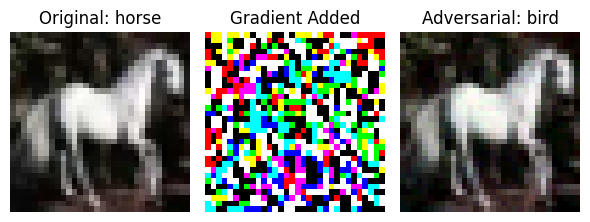

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


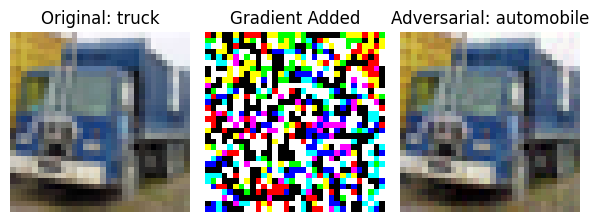

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


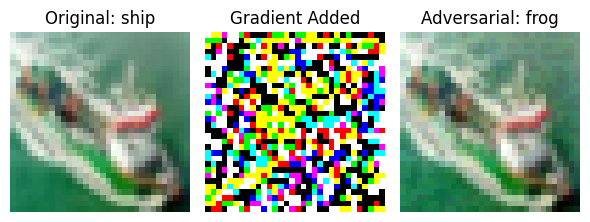

In [21]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def test_fgsm_attack(index = 0, num = 5, epsilon = 0.02):
    """
    Tests FGSM attack on a batch of images and visualizes the results.
    Displays the images below
    
    index: integer
        The starting index for the batch of images
    num: integer
        The number of images in the batch
    epsilon: float
        Strength of the FGSM attack.
    """
    for i in range(index, index + num):  # Visualize 5 examples
        image = X_test[i:i+1]  # Select one image (add batch dimension)
        label = y_test[i:i+1]  # True label of the image

        # Generate adversarial example
        adv_image, signed_grad = fgsm_attack(image, label, model, epsilon)

        # Get predictions for both clean and adversarial images
        clean_pred = model.predict(image)
        adv_pred = model.predict(adv_image)

        clean_class = class_labels[np.argmax(clean_pred)]
        adv_class = class_labels[np.argmax(adv_pred)]

        # Plot the results
        plt.figure(figsize=(6, 3))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image[0])
        plt.title(f"Original: {clean_class}")
        plt.axis('off')

        # Signed Gradient image
        plt.subplot(1, 3, 2)
        plt.imshow(signed_grad[0])
        plt.title(f"Gradient Added")
        plt.axis('off')

        # Adversarial image
        plt.subplot(1, 3, 3)
        plt.imshow(adv_image[0])
        plt.title(f"Adversarial: {adv_class}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        # plt.savefig(f'../img/fgmt_img{num + i}.png')
        

test_fgsm_attack(index = 13, num = 3, epsilon = 0.02)